https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

In [4]:
PATH = 'data/nyc-taxi/'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [5]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column) - thanks to the suggestion by mhviraf
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [6]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [7]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], usecols=cols_train,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    # Each chunk is a corresponding dataframe
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    # Can process each chunk of dataframe here
    # feature_engineer(), remove_outliers(), fit(), predict()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
Wall time: 4min 31s


In [8]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

In [9]:
del df_list

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [11]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [12]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

Wall time: 5.78 s


In [13]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

Wall time: 1.59 s


In [14]:
test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)

# Quick EDA

In [15]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [16]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12,-73.966049,40.789776,-73.988564,40.744427,1


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [17]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.54239e+07,NaN,5.54239e+07,5.54239e+07,5.54235e+07,5.54235e+07,5.54239e+07
mean,11.345,NaN,-72.5097,39.9198,-72.5111,39.9207,1.68538
std,20.7108,NaN,12.8489,9.64235,12.7822,9.63335,1.32766
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208
counts,55423856,55423856,55423856,55423856,55423480,55423480,55423856
uniques,9405,26173536,98330,116546,114629,134778,15


In [18]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,NaN,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875
min,NaN,-74.2522,40.5731,-74.2632,40.569,1
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2
max,NaN,-72.9865,41.7096,-72.991,41.6967,6
counts,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6


# Remove missing values

In [19]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [20]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [21]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 55423856
New size: 55423480


# Travel vector longitude, latitude and simple distance

In [22]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [23]:
def add_simple_distance(df):
    df['simple_distance'] = np.sqrt(df.abs_diff_longitude ** 2 + df.abs_diff_latitude ** 2)

In [24]:
add_travel_vector_features(train_df)
add_simple_distance(train_df)

In [25]:
add_travel_vector_features(test_df)
add_simple_distance(test_df)

In [26]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,5.54235e+07,NaN,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07
mean,11.345,NaN,-72.5099,39.9198,-72.5112,39.9207,1.68539,0.199236,0.122812,0.252637
std,20.7109,NaN,12.8488,9.64232,12.7822,9.63335,1.32766,9.44166,9.40297,13.3249
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0,0,0,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1,0.00580597,0.00658417,0.0123897
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1,0.0124359,0.0138588,0.0214342
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2,0.0237122,0.0269356,0.0383414
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208,6812.94,6818.56,8039.08
counts,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480
uniques,9391,26173267,98330,116546,114629,134778,15,91903,117299,16973659


In [27]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,NaN,9914,9914,9914,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127,0.0233484,0.0221326,0.0351464
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875,0.0367193,0.0255887,0.0424594
min,NaN,-74.2522,40.5731,-74.2632,40.569,1,0,0,0
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1,0.00635529,0.00727844,0.013261
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1,0.0131226,0.0147152,0.0224233
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2,0.0245628,0.0282612,0.0401673
max,NaN,-72.9865,41.7096,-72.991,41.6967,6,0.849174,0.633213,1.05733
counts,9914,9914,9914,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6,4896,6761,9820


In [28]:
len(train_df[(train_df.pickup_longitude < -180) | (train_df.pickup_longitude > 180)])

1295

In [29]:
len(train_df[(train_df.pickup_latitude < -90) | (train_df.pickup_latitude > 90)])

1013

In [30]:
len(train_df[(train_df.dropoff_longitude < -180) | (train_df.dropoff_longitude > 180)])

1184

In [31]:
len(train_df[(train_df.dropoff_latitude < -90) | (train_df.dropoff_latitude > 90)])

1019

In [32]:
print('Old size: %d' % len(train_df))

Old size: 55423480


In [33]:
train_df = train_df[(train_df.pickup_longitude >= -180) & (train_df.pickup_longitude <= 180)]

In [34]:
print('New size: %d' % len(train_df))

New size: 55422185


In [35]:
train_df = train_df[(train_df.pickup_latitude >= -90) & (train_df.pickup_latitude <= 90)]

In [36]:
print('New size: %d' % len(train_df))

New size: 55421702


In [37]:
train_df = train_df[(train_df.dropoff_longitude >= -180) & (train_df.dropoff_longitude <= 180)]

In [38]:
print('New size: %d' % len(train_df))

New size: 55421138


In [39]:
train_df = train_df[(train_df.dropoff_latitude >= -90) & (train_df.dropoff_latitude <= 90)]

In [40]:
print('New size: %d' % len(train_df))

New size: 55420735


2745 rows removed

## Range of min and max values from test set

The latitude of New York City, NY, USA is **40.730610**, and the longitude is **-73.935242**. 

In [41]:
plongmin, plongmax = test_df.pickup_longitude.min(),test_df.pickup_longitude.max()
plongmin, plongmax

(-74.25219, -72.986534)

In [42]:
dlongmin, dlongmax = test_df.dropoff_longitude.min(),test_df.dropoff_longitude.max()
dlongmin, dlongmax

(-74.263245, -72.99097)

In [43]:
platmin, platmax = test_df.pickup_latitude.min(),test_df.pickup_latitude.max()
platmin, platmax 

(40.573143, 41.709557)

In [44]:
dlatmin, dlatmax = test_df.dropoff_latitude.min(),test_df.dropoff_latitude.max()
dlatmin, dlatmax

(40.568974, 41.696682)

In [45]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07,5.542074e+07
mean,1.134504e+01,-7.249878e+01,3.991766e+01,-7.250305e+01,3.991993e+01,1.685384e+00,1.640693e-01,9.333889e-02,1.962079e-01
std,2.071122e+01,1.045485e+01,6.112569e+00,1.043685e+01,6.106028e+00,1.327632e+00,3.225071e+00,1.711757e+00,3.650799e+00
min,-3.000000e+02,-1.717973e+02,-7.783388e+01,-1.739576e+02,-7.435461e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00,5.805969e-03,6.584167e-03,1.238951e-02
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00,1.243591e-02,1.385880e-02,2.143336e-02
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00,2.371216e-02,2.693558e-02,3.833773e-02
max,9.396336e+04,1.699728e+02,8.974216e+01,1.699728e+02,8.981667e+01,2.080000e+02,2.290003e+02,1.185963e+02,2.305584e+02


In [46]:
len(train_df[(train_df.pickup_longitude < plongmin) | (train_df.pickup_longitude > plongmax)])

1107245

In [47]:
len(train_df[(train_df.dropoff_longitude < dlongmin ) | (train_df.dropoff_longitude > dlongmax)])

1103362

In [48]:
len(train_df[(train_df.pickup_latitude < platmin) | (train_df.pickup_latitude >platmax)])

1103349

In [49]:
len(train_df[(train_df.dropoff_latitude < dlatmin ) | (train_df.dropoff_latitude > dlatmax)])

1103981

In [50]:
len(train_df[(train_df.pickup_longitude < plongmin) | (train_df.pickup_longitude > plongmax) |
             (train_df.dropoff_longitude < dlongmin) | (train_df.dropoff_longitude > dlongmax) |
             (train_df.pickup_latitude < platmin) | (train_df.pickup_latitude > platmax) |
             (train_df.dropoff_latitude < dlatmin) | (train_df.dropoff_latitude > dlatmax)])

1183984

In [51]:
delta_long = 0
delta_lat = 0

In [52]:
a = len(train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)])
a

54236751

Each degree of latitude is approximately 69 miles (111 kilometers) apart.

In [53]:
delta_long = 1 # approx 111km allowance compared to test set
delta_lat = 1 # approx 111km allowance compared to test set

In [54]:
b = len(train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)])
b

54266046

In [55]:
b-a

29295

In [56]:
print('Old size: %d' % len(train_df))

Old size: 55420735


In [57]:
train_df = train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)]

In [58]:
print('New size: %d' % len(train_df))

New size: 54266046


In [59]:
print('Removed {:,} rows'.format(55420735 - 54247658))

Removed 1,173,077 rows


## Checkpoint 1

In [60]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [61]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt1')

Wall time: 9.56 s


In [62]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt1')

Wall time: 10.9 ms


In [114]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt1')

Wall time: 8.42 s


In [64]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt1')

Wall time: 1.98 ms


# Passenger Count

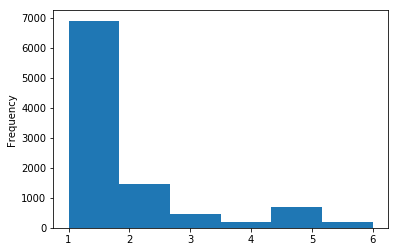

In [65]:
test_df.passenger_count.plot(kind='hist',bins=6)

In [66]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

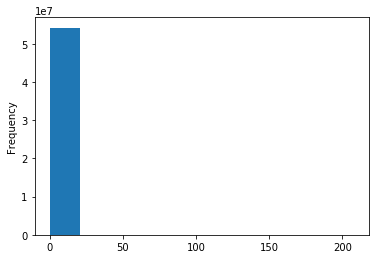

In [67]:
train_df.passenger_count.plot(kind='hist')

In [68]:
train_df.passenger_count.value_counts().sort_index()

0        190843
1      37527608
2       8015376
3       2383830
4       1155803
5       3842222
6       1150299
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [69]:
# number rows with passenger = 0 or more than 7
len(train_df[(train_df.passenger_count == 0) | (train_df.passenger_count > 7)])

190895

In [115]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.passenger_count > 0) & (train_df.passenger_count < 8)]
print('New size: %d' % len(train_df))

Old size: 54266046
New size: 54075151


# Distance

In [71]:
test_df.simple_distance.max(), test_df.abs_diff_latitude.max(),  test_df.abs_diff_longitude.max()

(1.0573337, 0.63321304, 0.8491745)

In [72]:
test_df.simple_distance.min(), test_df.abs_diff_latitude.min(),  test_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [73]:
(len(test_df[test_df.simple_distance == 0]), 
len(test_df[test_df.abs_diff_latitude == 0]),
len(test_df[test_df.abs_diff_longitude == 0]))

(85, 85, 87)

In [74]:
train_df.simple_distance.max(), train_df.abs_diff_latitude.max(), train_df.abs_diff_longitude.max()

(2.7406824, 1.9242516, 2.6350555)

In [75]:
train_df.simple_distance.min(), train_df.abs_diff_latitude.min(), train_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [76]:
(len(train_df[train_df.simple_distance == 0]), 
len(train_df[train_df.abs_diff_latitude == 0]),
len(train_df[train_df.abs_diff_longitude == 0]))

(585743, 601667, 615438)

In [77]:
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,585743.000000,585743.000000,585743.000000,585743.000000,585743.000000,585743.000000,585743.0,585743.0,585743.0
mean,11.299520,-73.945786,40.759052,-73.945786,40.759052,1.666932,0.0,0.0,0.0
std,16.200907,0.143907,0.106469,0.143907,0.106469,1.297104,0.0,0.0,0.0
min,-100.000000,-75.249725,39.603233,-75.249725,39.603233,1.000000,0.0,0.0,0.0
25%,4.900000,-73.990814,40.733528,-73.990814,40.733528,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975792,40.752193,-73.975792,40.752193,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948143,40.767773,-73.948143,40.767773,2.000000,0.0,0.0,0.0
max,3130.300049,-72.089333,42.641273,-72.089333,42.641273,6.000000,0.0,0.0,0.0


In [116]:
len(train_df[(train_df.abs_diff_latitude>test_df.abs_diff_latitude.max())])

8371

In [117]:
len(train_df[(train_df.abs_diff_longitude>test_df.abs_diff_longitude.max())])

2754

In [80]:
len(train_df[(train_df.simple_distance>test_df.simple_distance.max())])

8085

In [81]:
print('Old size: %d' % len(train_df))

Old size: 54075151


In [82]:
train_df = train_df[(train_df.abs_diff_latitude<=test_df.abs_diff_latitude.max()+1)]

In [83]:
print('New size: %d' % len(train_df))

New size: 54075127


In [84]:
train_df = train_df[(train_df.abs_diff_longitude<=test_df.abs_diff_longitude.max()+1)]

In [85]:
print('New size: %d' % len(train_df))

New size: 54075110


In [86]:
train_df = train_df[(train_df.simple_distance<=test_df.simple_distance.max()+1)]

In [87]:
print('New size: %d' % len(train_df))

New size: 54075110


# Fare Amount

In [88]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.333723)

In [89]:
train_df.fare_amount.quantile(0.99), train_df.fare_amount.quantile(0.9995)

(52.099998474121094, 91.0)

In [90]:
len(train_df[(train_df.fare_amount==0)])

1119

In [91]:
len(train_df[(train_df.fare_amount<0)])

2206

In [92]:
len(train_df[(train_df.fare_amount> train_df.fare_amount.quantile(0.9995))])

26975

In [93]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.fare_amount>0) & (train_df.fare_amount<150)]
print('New size: %d' % len(train_df))

Old size: 54075110
New size: 54067064


In [94]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,5.40671e+07,NaN,5.40671e+07,5.40671e+07,5.40671e+07,5.40671e+07,5.40671e+07,5.40671e+07,5.40671e+07,5.40671e+07
mean,11.3141,NaN,-73.9707,40.7501,-73.9705,40.7502,1.69112,0.0227984,0.0214413,0.0342285
std,9.52498,NaN,0.0391943,0.031978,0.0383179,0.0351353,1.30693,0.0351999,0.0268867,0.0420693
min,0.01,NaN,-75.2511,39.5778,-75.263,39.5707,1,0,0,0
25%,6,NaN,-73.9923,40.7366,-73.9916,40.7356,1,0.0061264,0.00692749,0.0128038
50%,8.5,NaN,-73.9821,40.7534,-73.9806,40.7539,1,0.0126877,0.0141602,0.0217953
75%,12.5,NaN,-73.9683,40.7676,-73.9653,40.7684,2,0.0239334,0.0271988,0.0386899
max,149.99,NaN,-71.9969,42.7041,-72.0021,42.6761,7,1.84062,1.62736,1.98204
counts,54067064,54067064,54067064,54067064,54067064,54067064,54067064,54067064,54067064,54067064
uniques,7622,25644824,70910,97393,85421,114095,7,48303,74752,16902675


## Checkpoint 2

In [95]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [96]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt2')

Wall time: 8.86 s


In [97]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt2')

Wall time: 10.9 ms


In [98]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt2')

Wall time: 1.73 s


In [99]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt2')

Wall time: 2.02 ms


# Date Time

In [100]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54067064 entries, 0 to 54067063
Data columns (total 10 columns):
fare_amount           float32
pickup_datetime       datetime64[ns]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
abs_diff_longitude    float32
abs_diff_latitude     float32
simple_distance       float32
dtypes: datetime64[ns](1), float32(8), uint8(1)
memory usage: 2.1 GB


In [101]:
%%time
add_datepart(train_df, 'pickup_datetime', time=True)

Wall time: 1min 33s


In [102]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54067064 entries, 0 to 54067063
Data columns (total 25 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
simple_distance                    float32
pickup_datetimeYear                int64
pickup_datetimeMonth               int64
pickup_datetimeWeek                int64
pickup_datetimeDay                 int64
pickup_datetimeDayofweek           int64
pickup_datetimeDayofyear           int64
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datetim

In [103]:
cols_to_drop = [
    'pickup_datetimeElapsed',
    'pickup_datetimeSecond'
]

In [104]:
train_df.drop(cols_to_drop, axis='columns', inplace=True)

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54067064 entries, 0 to 54067063
Data columns (total 23 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
simple_distance                    float32
pickup_datetimeYear                int64
pickup_datetimeMonth               int64
pickup_datetimeWeek                int64
pickup_datetimeDay                 int64
pickup_datetimeDayofweek           int64
pickup_datetimeDayofyear           int64
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datetim

In [106]:
train_df.pickup_datetimeYear = train_df.pickup_datetimeYear.astype('uint16')   
train_df.pickup_datetimeMonth = train_df.pickup_datetimeMonth.astype('uint8') 
train_df.pickup_datetimeDay = train_df.pickup_datetimeDay.astype('uint8')   
train_df.pickup_datetimeWeek = train_df.pickup_datetimeWeek.astype('uint8')    
train_df.pickup_datetimeHour = train_df.pickup_datetimeHour.astype('uint8')   
train_df.pickup_datetimeMinute = train_df.pickup_datetimeMinute.astype('uint8')    
train_df.pickup_datetimeDayofweek = train_df.pickup_datetimeDayofweek.astype('uint8')                 
train_df.pickup_datetimeDayofyear = train_df.pickup_datetimeDayofyear.astype('uint16')   

In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54067064 entries, 0 to 54067063
Data columns (total 23 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
simple_distance                    float32
pickup_datetimeYear                uint16
pickup_datetimeMonth               uint8
pickup_datetimeWeek                uint8
pickup_datetimeDay                 uint8
pickup_datetimeDayofweek           uint8
pickup_datetimeDayofyear           uint16
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datet

## Repeat on test dataframe

In [108]:
add_datepart(test_df, 'pickup_datetime', time=True)

In [109]:
test_df.drop(cols_to_drop, axis='columns', inplace=True)

In [110]:
test_df.pickup_datetimeYear = test_df.pickup_datetimeYear.astype('uint16')   
test_df.pickup_datetimeMonth = test_df.pickup_datetimeMonth.astype('uint8')   
test_df.pickup_datetimeDay = test_df.pickup_datetimeDay.astype('uint8')  
test_df.pickup_datetimeWeek = test_df.pickup_datetimeWeek.astype('uint8')    
test_df.pickup_datetimeHour = test_df.pickup_datetimeHour.astype('uint8')   
test_df.pickup_datetimeMinute = test_df.pickup_datetimeMinute.astype('uint8')    
test_df.pickup_datetimeDayofweek = test_df.pickup_datetimeDayofweek.astype('uint8')                 
test_df.pickup_datetimeDayofyear = test_df.pickup_datetimeDayofyear.astype('uint16')  

## Checkpoint 3

In [111]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt3')

Wall time: 8.13 s


In [112]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt3')

Wall time: 26.8 ms


In [ ]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt3')

In [ ]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt3')